# Why Modules

A typical training procedure for a neural net:

0. Define a dataset ($X$ and $Y$)
1. Define the neural network with some learnable weights
2. Iterate over the dataset
3. Pass inputs to the network (forward pass)
4. Compute the loss
5. Compute gradients w.r.t. network's weights (backward pass)
6. Update weights (e.g., weight = weight - lr * gradient)

PyTorch handles 1-6 for you via encapsulation, so you still have the flexibility to change something in between if you want!

## Example: MNIST classifier

The MNIST dataset is composed of images of digits that must be classified with labels from 0 to 9. The inputs are 28x28 matrices containing the grayscale intensity in each pixel.

We will download the MNIST dataset for training a classifier. PyTorch provides a convenient function for that.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt
torch.manual_seed(0)

# Dataset
It's easy to create your `Dataset`,
but PyTorch comes with several built-in datasets for [vision](https://pytorch.org/vision/stable/datasets.html), [audio](https://pytorch.org/audio/stable/datasets.html), and [text](https://pytorch.org/text/stable/datasets.html) modalities.

The class `Dataset` gives you information about the number of samples (implement `__len__`) and gives you the sample at a given index (implement `__getitem__`). It's a nice and simple abstraction to work with data. It has the following structure:

```python
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```

For now, let's use MNIST. But feel free to use another `Dataset` as an exercise.

In [2]:
from torch.utils.data import Dataset

In [3]:
# download MNIST and store it in "../data"
# PyTorch.datasets also handles caching for you so you don't have to download the dataset twice
train_data = datasets.MNIST('../data', train=True, download=True)
test_data = datasets.MNIST('../data', train=False)

train_x = train_data.data
train_y = train_data.targets
test_x = test_data.data
test_y = test_data.targets

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.52MB/s]


In [4]:
n_train_examples = train_x.shape[0]
n_test_examples = test_x.shape[0]
print('Training instances:', n_train_examples)
print('Test instances:', n_test_examples)

Training instances: 60000
Test instances: 10000


Check the shape of our training data to see how many input features we have:

In [5]:
train_x.shape, train_y.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

And what the images looks like:

tensor([[5, 0, 4, 1, 9, 2, 1, 3],
        [1, 4, 3, 5, 3, 6, 1, 7],
        [2, 8, 6, 9, 4, 0, 9, 1]])


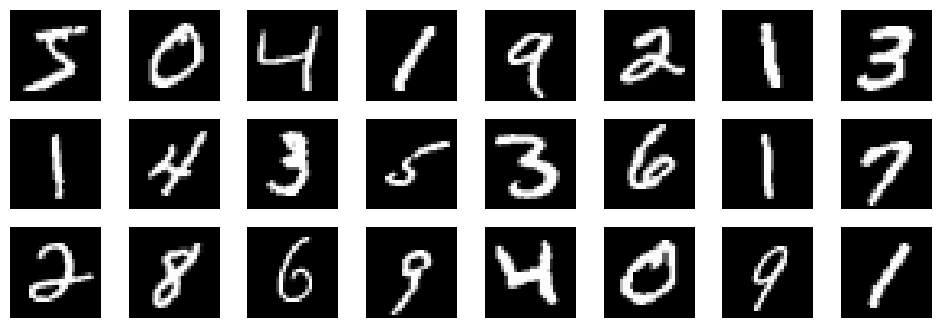

In [6]:
C = 8
fig, axs = plt.subplots(3, C, figsize=(12, 4))
for i in range(3):
    for j in range(C):
        axs[i, j].imshow(train_x[i*C + j], cmap='gray')
        axs[i, j].set_axis_off()
print(train_y[:24].reshape(3, C))

### Formatting

Each sample is a 28x28 matrix. But we want to represent them as vectors, since our model (which will be a simple MLP) doesn't take any advantage of the 2D nature of the data.

So, we reshape the data:

In [7]:
num_features = 28 * 28
train_x_vectors = train_x.view(n_train_examples, num_features)
print(train_x_vectors.shape)

torch.Size([60000, 784])


When we reshape an array (or torch tensor, for that matter), we don't need to specify all dimensions. We can leave one as -1, and it will be automatically determined from the size of the data. This is useful when we don't know a priori the shape of some array.

In [8]:
train_x_vectors = train_x.view(n_train_examples, -1)
test_x_vectors = test_x.view(n_test_examples, -1)

print(train_x_vectors.shape, test_x_vectors.shape)

torch.Size([60000, 784]) torch.Size([10000, 784])


Also, the values are integers in the range $[0, 255]$. It is better to work with float values in a smaller interval, such as $[0, 1]$ or $[-1, 1]$. There are some more elaborate normalization techniques, but for now let's just normalize the data into $[0, 1]$.

In [9]:
train_x_norm = train_x_vectors / 255.0
test_x_norm = test_x_vectors / 255.0
print(train_x_norm.max(), train_x_norm.min(), train_x_norm.mean(), train_x_norm.std())

tensor(1.) tensor(0.) tensor(0.1307) tensor(0.3081)


Now, let's check all the available labels:

In [10]:
print(torch.unique(train_y))
num_classes = len(torch.unique(train_y))
print('Num classes:', num_classes)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Num classes: 10


# Modules and MLPs

We've seen how the internals of a simple linear classifier work. However, we still had to set a lot of things manually. It's much better to have a higher-level API that encapsulates the classifier.

We are going to see that now, with pytorch Module objects. Then, it will allow us to build more complex models, like a multilayer perceptron.

We begin by loading, reshaping and normalizing the data again (so the code looks concise):

In [11]:
from torchvision.transforms import ToTensor

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST('../data', train=False, transform=ToTensor())

train_x = train_dataset.data
train_y = train_dataset.targets
test_x = test_dataset.data
test_y = test_dataset.targets

num_features = 28 * 28
num_classes = len(torch.unique(train_y))
new_shape = [-1, num_features]
train_x_vectors = train_x.reshape(new_shape)
test_x_vectors = test_x.reshape(new_shape)

# shorten the names
train_x = train_x_vectors.float() / 255
test_x = test_x_vectors.float() / 255

## Using Modules

PyTorch provides some basic building blocks for neural nets under `.nn` module. Here you can check the complete list of available blocks: https://pytorch.org/docs/stable/nn.html

For now, let's recreate a simple linear model using `nn.Linear` (see [doc](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)).

In [12]:
class LinearModel(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.linear_layer = nn.Linear(n_features, n_classes)

    def forward(self, X):
        # This is the same as doing:
        # return X @ self.linear_layer.weight.t() + self.linear_layer.bias
        # where weight and bias are instances of nn.Parameter
        return self.linear_layer(X)

linear_model = LinearModel(num_features, num_classes)

As before, the model can be called as function in order to produce an output:

In [13]:


batch = train_x[:2]
outputs = linear_model(batch)
outputs

tensor([[ 0.0991,  0.1537, -0.2098, -0.0753,  0.0583, -0.1490, -0.4113,  0.0951,
          0.2438, -0.2187],
        [-0.2016,  0.1073, -0.1494,  0.0880,  0.5348,  0.0917, -0.1303,  0.1279,
          0.2609, -0.1959]], grad_fn=<AddmmBackward0>)

Same as doing the forward method $$w^T x + b$$

In [14]:
batch @ linear_model.linear_layer.weight.t() + linear_model.linear_layer.bias

tensor([[ 0.0991,  0.1537, -0.2098, -0.0753,  0.0583, -0.1490, -0.4113,  0.0951,
          0.2438, -0.2187],
        [-0.2016,  0.1073, -0.1494,  0.0880,  0.5348,  0.0917, -0.1303,  0.1279,
          0.2609, -0.1959]], grad_fn=<AddBackward0>)

Now that we defined our model, we just have to:
- define an iterator
- define and compute the loss
- compute gradients
- define the strategy to update the parameters of our model
- glue previous steps to form the training loop!

#### Batching

Batching can be boring to code. PyTorch provides the `DataLoader` class to help us! Dealing with data is one of the most important yet more time consuming tasks. Take a look in the PyTorch `data` submodule to [learn more](https://pytorch.org/docs/stable/data.html).

In general, we just have to pass a torch `Dataset` object as input to the dataloader, and then set some hyperparams for the iterator:

In [15]:
from torch.utils.data import DataLoader
print(type(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

<class 'torchvision.datasets.mnist.MNIST'>


#### Loss

Here is the complete list of available [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions).
If the provided loss functions don't satisfy your constraints, it is easy to define your own loss function: just use torch operations (and be careful with differentiability issues). For example:

In [16]:
with torch.no_grad():  # disable gradient-tracking

    dummy_loss = nn.CrossEntropyLoss()

    # try other losses!
    # multi-class classification hinge loss (margin-based loss):
    # dummy_loss = nn.MultiMarginLoss()
    batch = train_x[:2]
    targets = train_y[:2]
    predictions = linear_model(batch)

    print(predictions.shape, targets.shape)
    print(dummy_loss(predictions, targets))

torch.Size([2, 10]) torch.Size([2])
tensor(2.5059)


And writing our own function (from the definition of the Cross Entropy loss):

$$
CE(p,y) = - \log\frac{\exp(p_y)}{\sum_c \exp(p_c)}
$$

In [17]:
def dummy_loss(y_pred, y):
    one_hot = y.unsqueeze(1) == torch.arange(num_classes).unsqueeze(0)
    res = - torch.log(torch.exp(y_pred) / torch.exp(y_pred).sum(-1).unsqueeze(-1))[one_hot]
    return res.mean()  # average per sample

print(dummy_loss(predictions, targets))

tensor(2.5059)


We will use the CrossEntropy function as our loss

In [18]:
loss_function = nn.CrossEntropyLoss()

#### Optimizer

The optimizer is the object which handles the update of the model's parameters. In the previous exercise, we were using the famous "delta" rule to update our weights:

$$\mathbf{w}_t = \mathbf{w}_{t-1} - \alpha \frac{\partial L}{\partial \mathbf{w}}.$$

But there are more ellaborate ways of updating our parameters:

<!-- <img src="http://cs231n.github.io/assets/nn3/opt2.gif" width="45%" /> -->

<img src="http://cs231n.github.io/assets/nn3/opt1.gif" width="45%" />


PyTorch provides an extensive list of optimizers: https://pytorch.org/docs/stable/optim.html. Notice that, as everything else, it should be easy to define your own optimizer procedure.

We will use the simple yet powerful SGD optmizer. The optimizer needs to be told which are the parameters to optimize.

In [19]:
parameters = linear_model.parameters()  # we will optimize all model's parameters!
optimizer = torch.optim.SGD(parameters, lr=0.1)

#### Training loop

Now we write the main training loop. This is the basic skeleton for training PyTorch models.

In [20]:
def train_model(model, dataloader, optimizer, loss_function, num_epochs=1):
    # Tell PyTorch that we are in training mode.
    # This is useful for mechanisms that work differently during training and test time, like Dropout.
    model.train()

    losses = []
    for epoch in range(1, num_epochs+1):
        print('Starting epoch %d' % epoch)
        total_loss = 0
        hits = 0

        for batch_x, batch_y in dataloader:
            # check shapes with:
            # import ipdb; ipdb.set_trace()
            # batch_x.shape is (batch_size, 28, 28)
            # batch_y.shape is (batch_size, )

            # Step 1. Remember that PyTorch accumulates gradients.
            # We need to clear them out before each step
            optimizer.zero_grad()

            # Step 2. Preprocess the data
            # (batch_size, 28, 28) -> (batch_size, 784 = 28 * 28)
            batch_x = batch_x.reshape(batch_x.shape[0], -1)
            batch_x = batch_x.to(torch.float) / 255.0

            # Step 3. Run forward pass.
            logits = model(batch_x)

            # Step 4. Compute loss
            loss = loss_function(logits, batch_y)

            # Step 5. Compute gradeints
            loss.backward()

            # Step 6. After determining the gradients, take a step toward their (neg-)direction
            optimizer.step()

            # Optional. Save statistics of your training
            loss_value = loss.item()
            total_loss += loss_value
            losses.append(loss_value)
            y_pred = logits.argmax(dim=1)
            hits += torch.sum(y_pred == batch_y).item()

        avg_loss = total_loss / len(train_dataloader.dataset)
        print('Epoch loss: %.4f' % avg_loss)
        acc = hits / len(train_dataloader.dataset)
        print('Epoch accuracy: %.4f' % acc)

    print('Done!')
    return losses

In [21]:
linear_losses = train_model(linear_model, train_dataloader, optimizer, loss_function, num_epochs=10)

Starting epoch 1
Epoch loss: 0.0360
Epoch accuracy: 0.1111
Starting epoch 2
Epoch loss: 0.0359
Epoch accuracy: 0.1125
Starting epoch 3
Epoch loss: 0.0359
Epoch accuracy: 0.1124
Starting epoch 4
Epoch loss: 0.0359
Epoch accuracy: 0.1159
Starting epoch 5
Epoch loss: 0.0359
Epoch accuracy: 0.1154
Starting epoch 6
Epoch loss: 0.0358
Epoch accuracy: 0.1216
Starting epoch 7
Epoch loss: 0.0358
Epoch accuracy: 0.1177
Starting epoch 8
Epoch loss: 0.0358
Epoch accuracy: 0.1160
Starting epoch 9
Epoch loss: 0.0358
Epoch accuracy: 0.1273
Starting epoch 10
Epoch loss: 0.0357
Epoch accuracy: 0.1193
Done!


Graphics are good to understand the performance of a model. Let's plot the loss curve by training step:

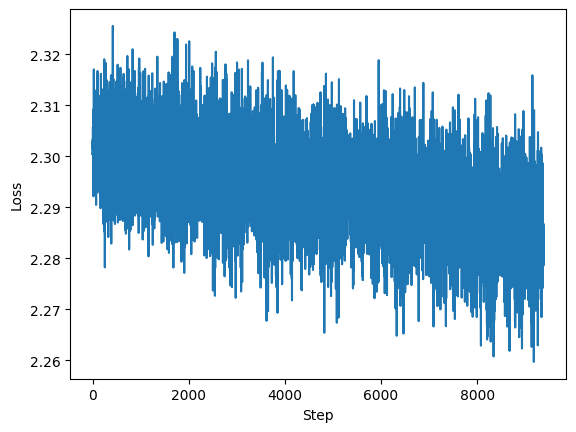

In [22]:
fig, ax = plt.subplots()
ax.plot(linear_losses, "-")
ax.set_xlabel('Step')
ax.set_ylabel('Loss');

What can you conclude from this?

## Multilayer Perceptron

We can now proceed to a more sofisticated classifier: a multilayer perceptron. Let's build one using the Sequential API.

In [23]:
class MLP(nn.Module):
    def __init__(self, n_features, hidden_size, n_classes):
        super().__init__()
        linear_layer1 = nn.Linear(n_features, hidden_size)
        linear_layer2 = nn.Linear(hidden_size, hidden_size)
        linear_layer3 = nn.Linear(hidden_size, n_classes)
        self.feedforward = nn.Sequential(
            linear_layer1,
            nn.Tanh(),
            linear_layer2,
            nn.Tanh(),
            linear_layer3
        )

    def forward(self, X):
        return self.feedforward(X)

hidden_size = 200
mlp = MLP(num_features, hidden_size, num_classes)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.1)

Now let's train the model.

In [24]:
mlp_losses = train_model(mlp, train_dataloader, optimizer, loss_function, num_epochs=50)

Starting epoch 1
Epoch loss: 0.0360
Epoch accuracy: 0.1100
Starting epoch 2
Epoch loss: 0.0360
Epoch accuracy: 0.1121
Starting epoch 3
Epoch loss: 0.0360
Epoch accuracy: 0.1121
Starting epoch 4
Epoch loss: 0.0360
Epoch accuracy: 0.1133
Starting epoch 5
Epoch loss: 0.0360
Epoch accuracy: 0.1139
Starting epoch 6
Epoch loss: 0.0359
Epoch accuracy: 0.1161
Starting epoch 7
Epoch loss: 0.0359
Epoch accuracy: 0.1171
Starting epoch 8
Epoch loss: 0.0359
Epoch accuracy: 0.1272
Starting epoch 9
Epoch loss: 0.0358
Epoch accuracy: 0.1565
Starting epoch 10
Epoch loss: 0.0354
Epoch accuracy: 0.1899
Starting epoch 11
Epoch loss: 0.0346
Epoch accuracy: 0.2059
Starting epoch 12
Epoch loss: 0.0337
Epoch accuracy: 0.2199
Starting epoch 13
Epoch loss: 0.0327
Epoch accuracy: 0.2570
Starting epoch 14
Epoch loss: 0.0315
Epoch accuracy: 0.2873
Starting epoch 15
Epoch loss: 0.0305
Epoch accuracy: 0.3108
Starting epoch 16
Epoch loss: 0.0295
Epoch accuracy: 0.3308
Starting epoch 17
Epoch loss: 0.0283
Epoch accura

How do the loss and accuracy compare with the linear model?

You probably also noticed a difference in running time!

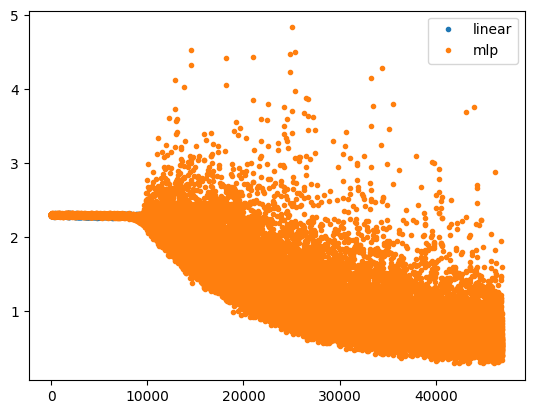

In [25]:
fig, ax = plt.subplots()
ax.plot(linear_losses, ".", label="linear")
ax.plot(mlp_losses, ".", label="mlp")
ax.legend()

Note the different concentration of dots in the MLP and Linear graphics!

### Validation data

Evaluating the performance on training data is important to understand if the model is actually learning, but if we want to know if our model has any usefulness, we should evaluate its performance on validation or test data.



In [26]:
def evaluate_model(model, test_x, test_y):
    # Tell PyTorch that we are in evaluation mode.
    model.eval()

    with torch.no_grad():
        loss_function = torch.nn.CrossEntropyLoss()
        logits = model(test_x)
        loss = loss_function(logits, test_y)

        y_pred = logits.argmax(dim=1)
        hits = torch.sum(y_pred == test_y).item()

    return loss.item() / len(test_x), hits / len(test_x)

In [27]:
evaluate_model(mlp, train_x, train_y)

(3.18557600180308e-05, 0.767)

In [28]:
evaluate_model(mlp, test_x, test_y)

(0.0001852129340171814, 0.7721)

In [29]:
evaluate_model(linear_model, train_x, train_y)

(1.9363880157470704e-05, 0.6242666666666666)

In [30]:
evaluate_model(linear_model, test_x, test_y)

(0.00011472218036651612, 0.6347)

How can we make our model better? There are two things to be done:

1. **Hyperparameter search**. Do a grid search or random search on the hyperparameters (hidden size, learning rate, batch size, activation function, type of optimizer, ...)
2. **Generalize better**. This include either finding some better feature representation or regularizing, i.e., add some kind of penalty to the model weights that encourages it to find a more general solution. Examples: L2-norm weight regularization, dropout.
3. **Early stop**. Evaluate the model on validation data after each epoch or some number of batches; only save it when validation performance increases. This means detecting when the model achieved its performance peak.

#### Dropout

We could try dropout. It effectivelly deactivates some neural connections at random, forcing the network to avoid depending on specific inputs.

In [31]:
class MLPDropout(nn.Module):
    def __init__(self, n_features, hidden_size, n_classes, p_dropout):
        super().__init__()
        linear_layer1 = nn.Linear(n_features, hidden_size)
        linear_layer2 = nn.Linear(hidden_size, n_classes)
        self.feedforward = nn.Sequential(
            linear_layer1,
            nn.Tanh(),
            nn.Dropout(p_dropout),
            linear_layer2
        )

    def forward(self, X):
        return self.feedforward(X)

hidden_size = 200
p_dropout = 0.5
mlp_dropout = MLPDropout(num_features, hidden_size, num_classes, p_dropout)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp_dropout.parameters(), lr=0.1)

In [32]:
losses = train_model(mlp_dropout, train_dataloader, optimizer, loss_function, num_epochs=50)

Starting epoch 1
Epoch loss: 0.0360
Epoch accuracy: 0.1113
Starting epoch 2
Epoch loss: 0.0360
Epoch accuracy: 0.1126
Starting epoch 3
Epoch loss: 0.0360
Epoch accuracy: 0.1133
Starting epoch 4
Epoch loss: 0.0359
Epoch accuracy: 0.1155
Starting epoch 5
Epoch loss: 0.0359
Epoch accuracy: 0.1185
Starting epoch 6
Epoch loss: 0.0359
Epoch accuracy: 0.1209
Starting epoch 7
Epoch loss: 0.0359
Epoch accuracy: 0.1287
Starting epoch 8
Epoch loss: 0.0358
Epoch accuracy: 0.1372
Starting epoch 9
Epoch loss: 0.0357
Epoch accuracy: 0.1532
Starting epoch 10
Epoch loss: 0.0356
Epoch accuracy: 0.1700
Starting epoch 11
Epoch loss: 0.0355
Epoch accuracy: 0.1917
Starting epoch 12
Epoch loss: 0.0353
Epoch accuracy: 0.2204
Starting epoch 13
Epoch loss: 0.0350
Epoch accuracy: 0.2475
Starting epoch 14
Epoch loss: 0.0346
Epoch accuracy: 0.2719
Starting epoch 15
Epoch loss: 0.0340
Epoch accuracy: 0.2952
Starting epoch 16
Epoch loss: 0.0333
Epoch accuracy: 0.3212
Starting epoch 17
Epoch loss: 0.0324
Epoch accura

Training loss is a bit worse, as expected. After all, we are obstructing some connections.

Now let's check validation performance:

In [33]:
evaluate_model(mlp, test_x, test_y)

(0.0001852129340171814, 0.7721)

In [34]:
evaluate_model(mlp_dropout, test_x, test_y)

(0.0010507497787475585, 0.7357)

No improvement. Ideally, we should retrain our model with different hyperparamters (learning rates, layer sizes, number of layers, dropout rate) as well as some changes in the structure (different optimizers, activation functions, losses). However, data representation plays a key role.

<br>
<center>
<i>Do you think representing the input as independent pixels is a good idea for recognizing digits?</i>
</center>

### Saving

Persisting the model after training is obviously important to reuse it later. In Pytorch, we can save the model calling `save()` and passing  the model's `state_dict` (a Python dict that maps all parameters name to their actual tensors).

In [35]:
torch.save(mlp.state_dict(), 'mlp.model')

Later, recreate the model and load the data.

In [36]:
mlp2 = MLP(num_features, hidden_size, num_classes)
mlp2.load_state_dict(torch.load('mlp.model'))

<All keys matched successfully>

Let's check the performance to see if it's the same!

In [37]:
evaluate_model(mlp, test_x, test_y)

(0.0001852129340171814, 0.7721)

### Exercises

- Try running the MLP example for more epochs
- Try using CNNs: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [85]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 5 * 5, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [86]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
# test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

train_x = train_data.data
train_y = train_data.targets
test_x  = test_data.data
test_y  = test_data.targets



In [87]:
train_x.shape

torch.Size([60000, 28, 28])

In [88]:
cnn_model = CNN()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)


In [89]:
def cnn_train_model(model, train_x, train_y, optimizer, loss_fn, batch_size, num_epochs):
    model.train()
    n = train_x.size(0)

    for epoch in range(num_epochs):
        total_loss = 0
        hits = 0

        for i in range(0, n, batch_size):
            optimizer.zero_grad()

            batch_x = train_x[i:i+batch_size]
            batch_y = train_y[i:i+batch_size]

            batch_x = batch_x.unsqueeze(1).float() / 255.0  # (B,1,28,28)

            logits = model(batch_x)
            loss = loss_fn(logits, batch_y)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_x.size(0)
            hits += (logits.argmax(1) == batch_y).sum().item()
            # print('Epoch loss: %.4f' % total_loss)

            # print('Epoch accuracy: %.4f' % acc)

        print(f"Epoch {epoch+1} | Loss: {total_loss/n:.4f} | Acc: {hits/n:.4f}")


In [95]:
def evaluate_model(model, test_x, test_y, batch_size=64):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()

    total_loss = 0
    correct = 0
    n = test_x.size(0)

    with torch.no_grad():
        for i in range(0, n, batch_size):
            x = test_x[i:i+batch_size]
            y = test_y[i:i+batch_size]

            x = x.unsqueeze(1).float() / 255.0

            logits = model(x)
            loss = loss_fn(logits, y)

            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()

    return total_loss / n, correct / n


In [97]:
cnn_losses = cnn_train_model(cnn_model,train_x,train_y,optimizer, loss, batch_size=64,num_epochs=5)

Epoch 1 | Loss: 0.0009 | Acc: 0.9997
Epoch 2 | Loss: 0.0011 | Acc: 0.9997
Epoch 3 | Loss: 0.0019 | Acc: 0.9994
Epoch 4 | Loss: 0.0009 | Acc: 0.9997
Epoch 5 | Loss: 0.0018 | Acc: 0.9995


In [98]:
evaluate_model(cnn_model, test_x, test_y)

(0.07498605547101454, 0.9896)